# 1. Imports

In [1]:
# import psycopg2 as pg
import pandas  as pd
import numpy   as np
import seaborn as sns
import scikitplot as skplt

from sklearn    import ensemble        as en
from sklearn    import neighbors       as nh
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms
from sklearn    import linear_model    as lm
from matplotlib import pyplot          as plt

# 2. In case of importing via Database

In [2]:
# Credentials ==========================================================
# host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
# port = 5432
# database = 'comunidadedsdb'
# username = 'member'
# pwd = '**********'

# Schema Query =========================================================

# conn = pg.connect(user=username,
#                   password=pwd,
#                   host=host,
#                   port=port,
#                   database=database)

# cursor = conn.cursor()

# query_schema = """
#     SELECT nspname
#     FROM pg_catalog.pg_namespace
# """

# cursor.execute(query_schema)

# record = cursor.fetchall()
# cursor.close()
# conn.close()

# Table Query ==========================================================

# query_tables = """
#     SELECT tablename
#     FROM pg_tables
#     WHERE schemaname = 'pa004'
# """

# cursor.execute(query_tables)
# record = cursor.fetchall()
# print(record)

# cursor.close()
# conn.close() 

# Collecting Data ======================================================

# query_tables_users = """
#     SELECT *
#     FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
#                        LEFT JOIN pa004.insurance i ON (u.id = i.id)
#     WHERE u.age > 44
#     LIMIT 10
# """
# df = pd.read_sql(query_tables, conn)
# df = df.drop(df.columns[[5,9]], axis=1)
# df.head()

# 3. Loading Data

In [3]:
df_raw = pd.read_csv('../data/train.csv')
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 4. Data Description

In [4]:
df1 = df_raw.copy()

cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage',
            'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 4.1 Data Dimension

In [5]:
df1.shape

(381109, 12)

## 4.2 Data Types

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 4.3 Check NA

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 4.4 Data Descriptive

In [8]:
num_attributes = df1.select_dtypes(include=(['int64', 'float64']))
cat_attributes = df1.select_dtypes(exclude=(['int64', 'float64', 'datetime64[ns]']))

In [9]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
             'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 5. Feature Engineering

In [10]:
df2 = df1.copy()

In [11]:
# vehicle age
df2['vehicle_age'] = (df2['vehicle_age']
                      .apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                             'between_1_2_years' if x == '1-2 Year' else
                             'below_1_year'))


# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes'
                                                    else 0)

# 6. Data Filtering

In [12]:
df3 = df2.copy()

# 7. EDA

In [13]:
df4 = df3.copy()

# Para projetos de classificação, queremos separar duas classes ou dois grupos.
# Neste caso, um grupo interessado em seguro de carro e outro não.

## 7.1 Univariate Analysis

### 7.1.1 Age

- Há muito volume (25.000) em 'não interessados' concentrados em idade de 20-25 anos.
- Há pouco volume (1.750) em 'interessados'. A maior concentração é em pessoas de 40-50 anos.
- Está variável é promissora por separar o conjunto em duas classes, porém se apresenta desbalanceada.

<Axes: xlabel='response', ylabel='age'>

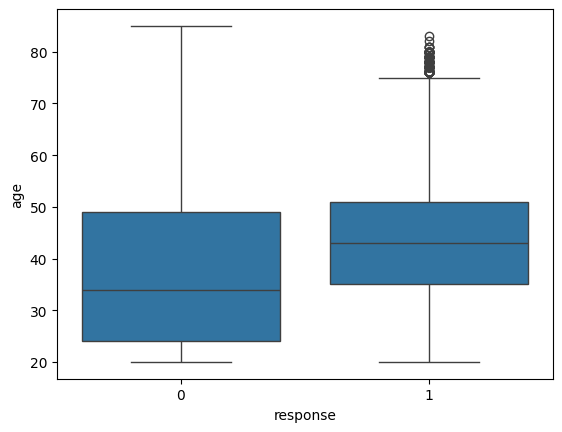

In [14]:
sns.boxplot(x='response', y='age', data=df4)

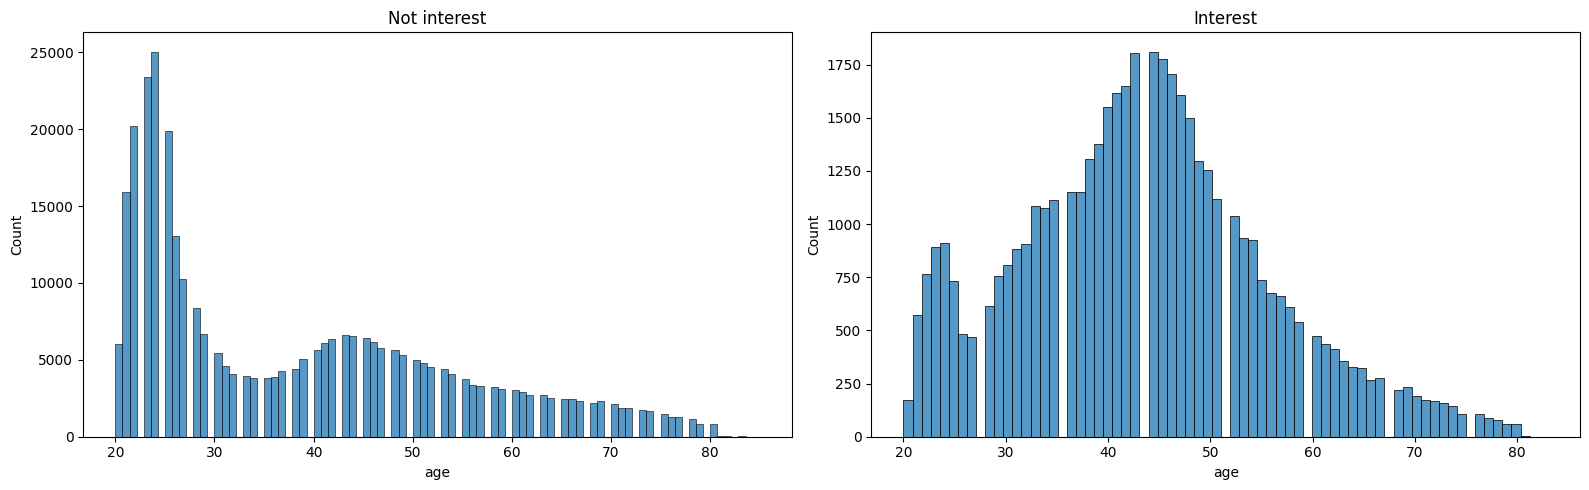

In [15]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.1.2 Annual Premium

- Esta variável sozinha não se apresenta relevante. Talvez combinada com outra.
- Formas e medianas parecidas. Não consegue segmentar grupos.

<Axes: xlabel='response', ylabel='annual_premium'>

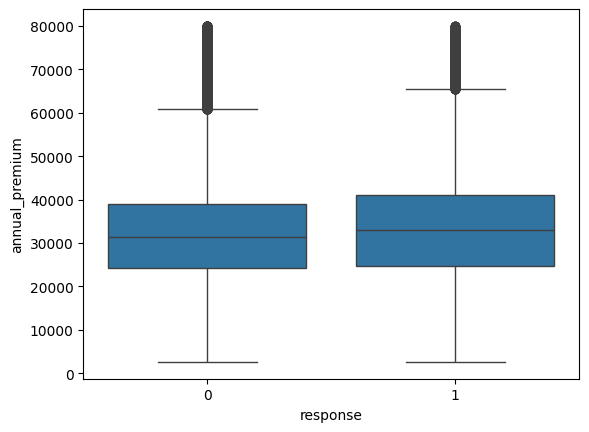

In [16]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

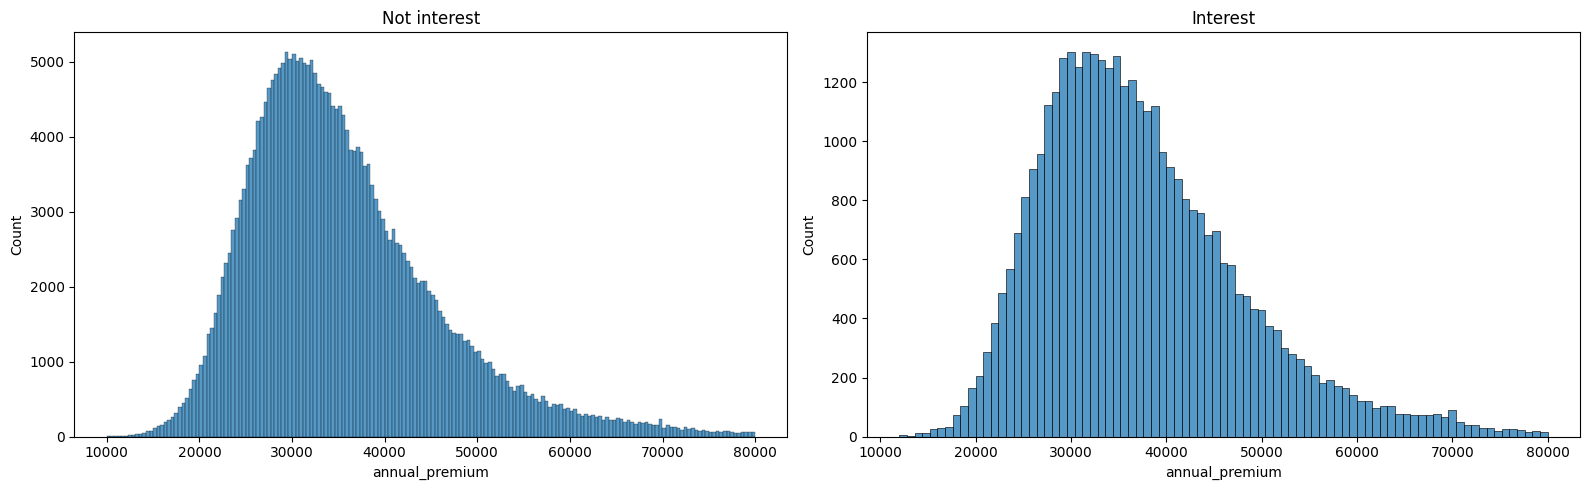

In [17]:
plt.figure(figsize=(16,5))
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.1.3 Driving License

- Há segmentação de grupos. Variável importante, mas deve ser combinada com age.
- Há muitas pessoas com driving license que não querem seguro de carro. Investigar o motivo.

In [18]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='response', ylabel='driving_license'>

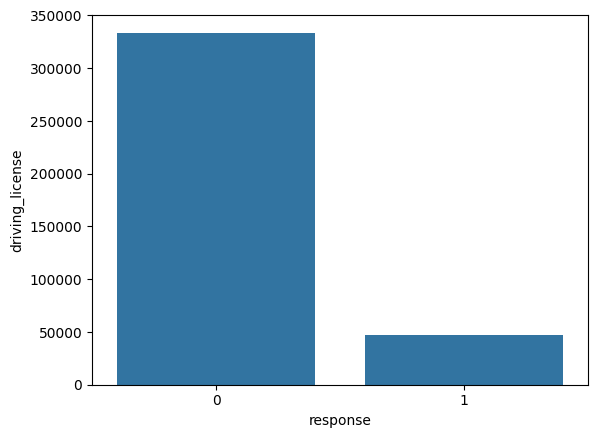

In [19]:
sns.barplot(x='response', y='driving_license', data=aux)

### 7.1.4 Region Code

- Não criou grupos de clusters.
- Sozinha, esta variável não é interessante. Talvez combinada com outra variável seja útil.

<Axes: xlabel='region_code', ylabel='id'>

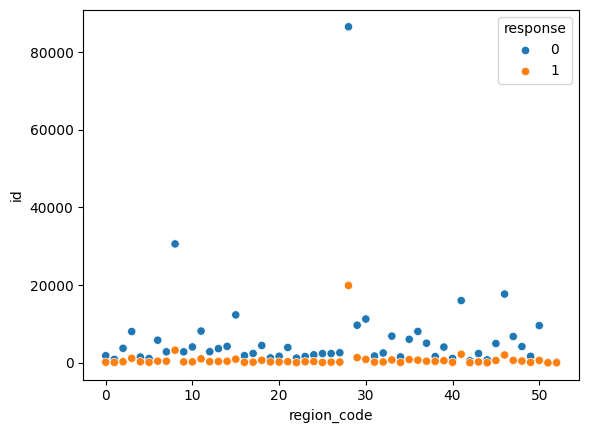

In [20]:
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(data=aux0, x='region_code', y='id', hue='response')

### 7.1.5 Previously Insured

- Pessoas que já possuem seguro veicular não querem trocar seu seguro pelo da empresa.
- Há vazamento de dados: a variavel previously_insurance é quase dizer ao modelo a resposta.
- A correlação com a variavel resposta é muito alta, como se quem já tem seguro veicular não compraria o seguro da empresa.
- Quase um if/else (se tem seguro -> não compra) 

In [21]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### 7.1.6 Vehicle Age

- Para carros novos de até 1 ano e aqueles de 1-2 anos, há discriminação de grupos.
- Para os mais velhos, os grupos são parecidos.

In [22]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')
# sns.scatterplot(data=aux0, x='vehicle_age', y='id', hue='response')

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_years,0,0.434285
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 7.1.7 Vehicle Damage

- Pessoas com veiculo danificado possuem mais propensão a comprar do que sem danos.

In [23]:
df4[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_damage')

,vehicle_damage,response,proportion
0,0,0,0.492547
3,0,1,0.002577
1,1,0,0.384890
2,1,1,0.119987


### 7.1.8 Gender

- Há clusterização de grupos.

In [24]:
df4[['gender', 'response']].value_counts(normalize=True).reset_index().sort_values('gender')

,gender,response,proportion
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


### 7.1.9 Policy Sales Channel

- Canais 43 e 123 são os melhores para quem quer o seguro.

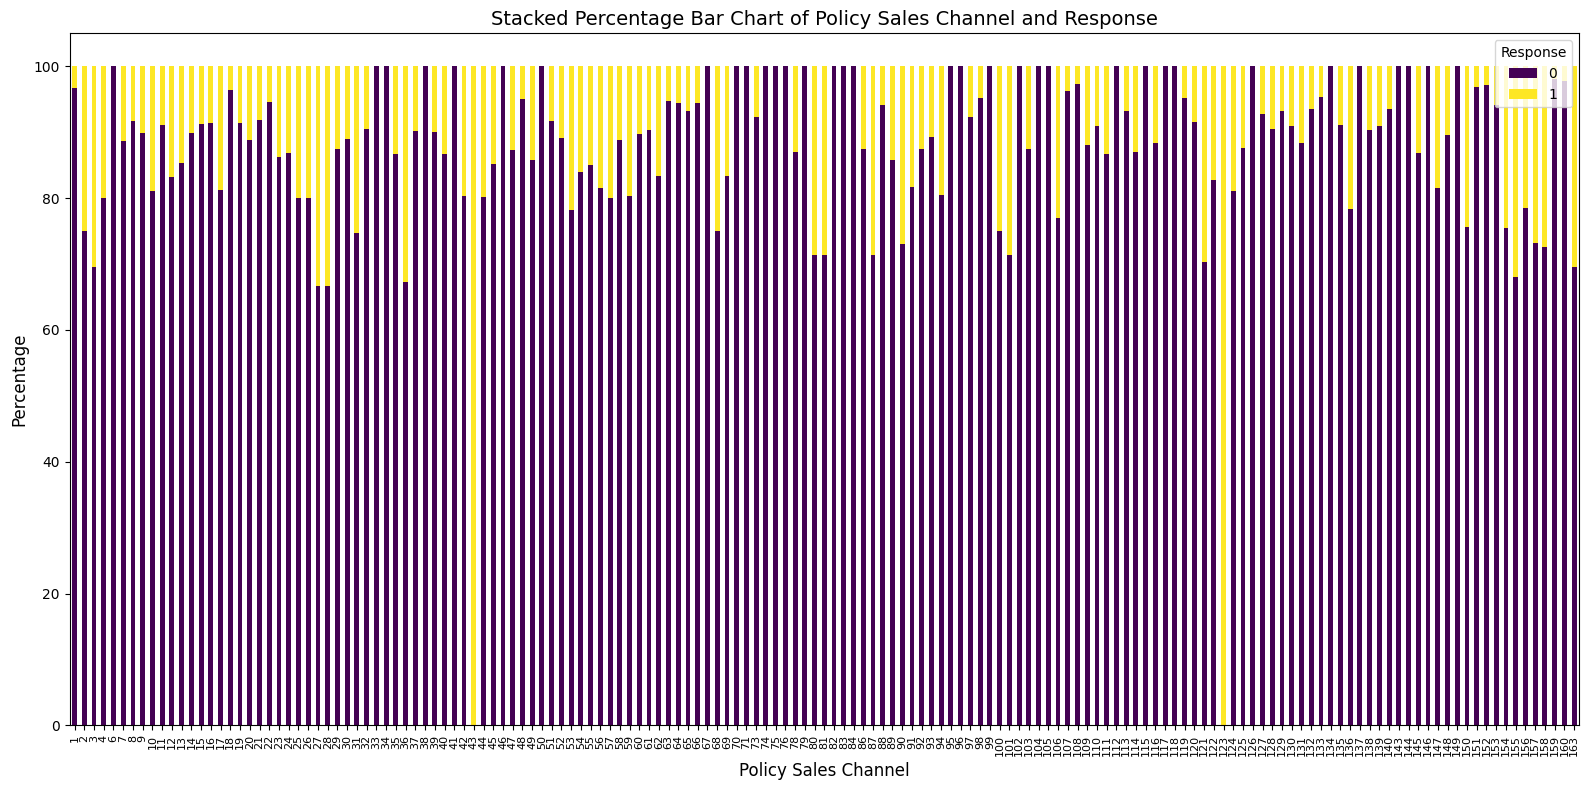

In [25]:
# Prepare the data for the stacked bar chart
stacked_data = (df4.groupby(['policy_sales_channel', 'response']).size()
                .unstack(fill_value=0))

# Convert counts to percentages
stacked_data_percentage = stacked_data.div(stacked_data.sum(axis=1),
                                           axis=0) * 100

# Plot
stacked_data_percentage.plot(kind='bar', stacked=True, figsize=(16, 8),
                             colormap='viridis')

# Add labels and title
plt.title('Stacked Percentage Bar Chart of Policy Sales Channel and Response',
          fontsize=14)
plt.xlabel('Policy Sales Channel', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Response', loc='upper right', fontsize=10)
plt.xticks(range(len(stacked_data_percentage.index)), 
           labels=stacked_data_percentage.index.astype(int), 
           rotation=90, fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


### 7.1.10 Vintage

- Não há segmentação de grupos. Os dados estão homogêneos. 
- A distribuição é uniforme.
- Variável irrelevante.

<Axes: xlabel='response', ylabel='vintage'>

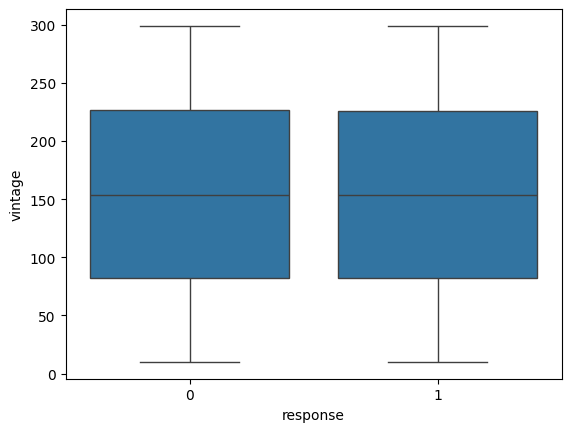

In [26]:
sns.boxplot(x='response', y='vintage', data=df4)

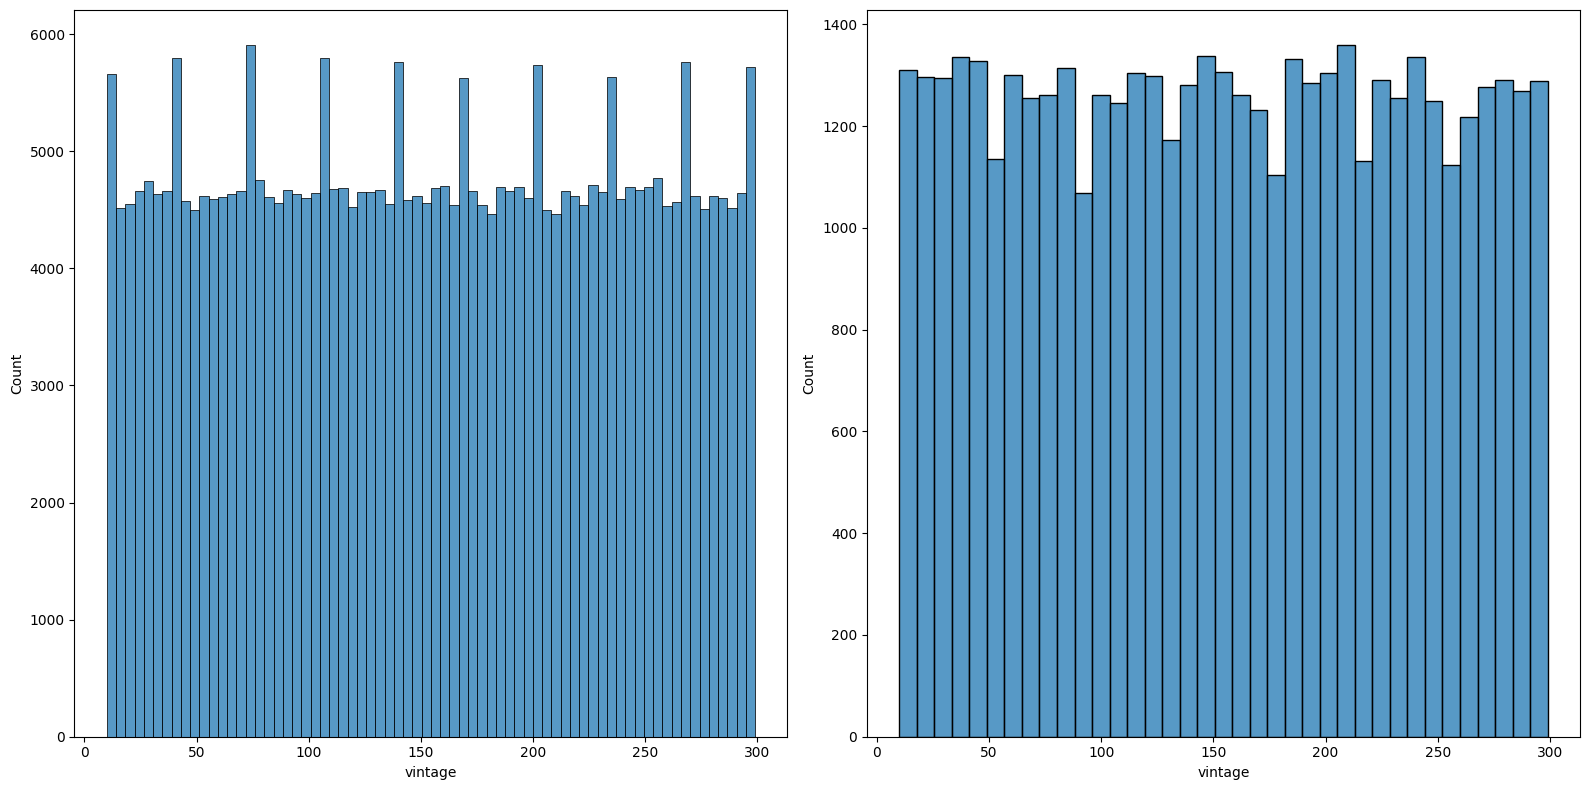

In [27]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux) 

plt.subplot(1, 2, 2)
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

# 8. Data Preparation

In [28]:
df5 = df4.copy()

In [29]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)
df5 = pd.concat([x_train, y_train], axis=1)

## 8.1 Standardzation

In [30]:
# annual_premium
ss = pp.StandardScaler()

df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 8.2 Rescaling

In [31]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 8.3 Encoder

In [32]:
# gender - One Hot Encoding / Target Encoding
target_encoding_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encoding_gender)

# region_code -  One Hot Encoding (até 6 tipos diferentes) / Frequency Encoding / Target Encoding / Weighted Encoding
target_encoding_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encoding_region_code)

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

## 8.4 Validation Preparation

In [33]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encoding_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encoding_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

C:\Users\Felipe\AppData\Local\Temp\ipykernel_14036\748696200.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.04615385 0.53846154 0.29230769 ... 0.01538462 0.16923077 0.09230769]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)
C:\Users\Felipe\AppData\Local\Temp\ipykernel_14036\748696200.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.65051903 0.5467128  0.75432526 ... 0.42906574 0.20069204 0.83391003]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x_validation.loc[:, 'vintage'] = mms_vintage.transform(x_validation[['vintage']].values)
C:\Users\Felipe\AppData\Local\Temp\ipykernel_14036\748696200.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi

# 9. Feature Selection

In [34]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking
                         feature  importance
0                        vintage    0.273920
0                 annual_premium    0.244399
0                            age    0.165417
0                    region_code    0.104348
0                 vehicle_damage    0.068802
0           policy_sales_channel    0.059819
0             previously_insured    0.055384
0       vehicle_age_below_1_year    0.013904
0  vehicle_age_between_1_2_years    0.006325
0                         gender    0.004768
0       vehicle_age_over_2_years    0.002382
0                driving_license    0.000531


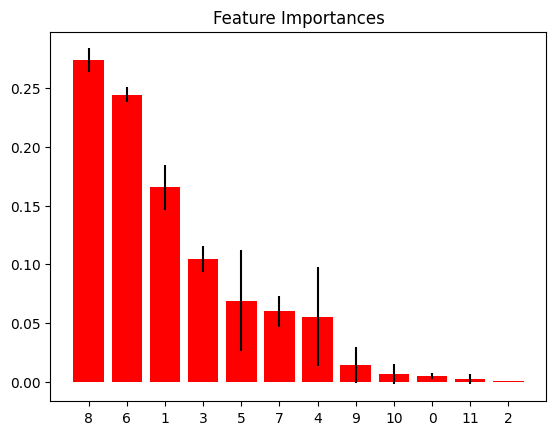

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 10. Machine Learning

- Não estamos querendo encontrar o melhor modelo para saber se a pessoa vai comprar ou nao.
- A intenção é criar uma lista com ranking das pessoas com maior probabilidade de compra.
- Estamos interessados em um modelo bom capaz de ordenar uma lista. Por isso usamos métricas de ordenação (curva acumulada)

In [43]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                 'vehicle_damage', 'policy_sales_channel',
                 'previously_insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 10.1 KNN

In [37]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(x_val)

## 10.2 Logistic Regression

In [38]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

## 10.3 Extra Tree

In [39]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

## 10.4 Models Comparation

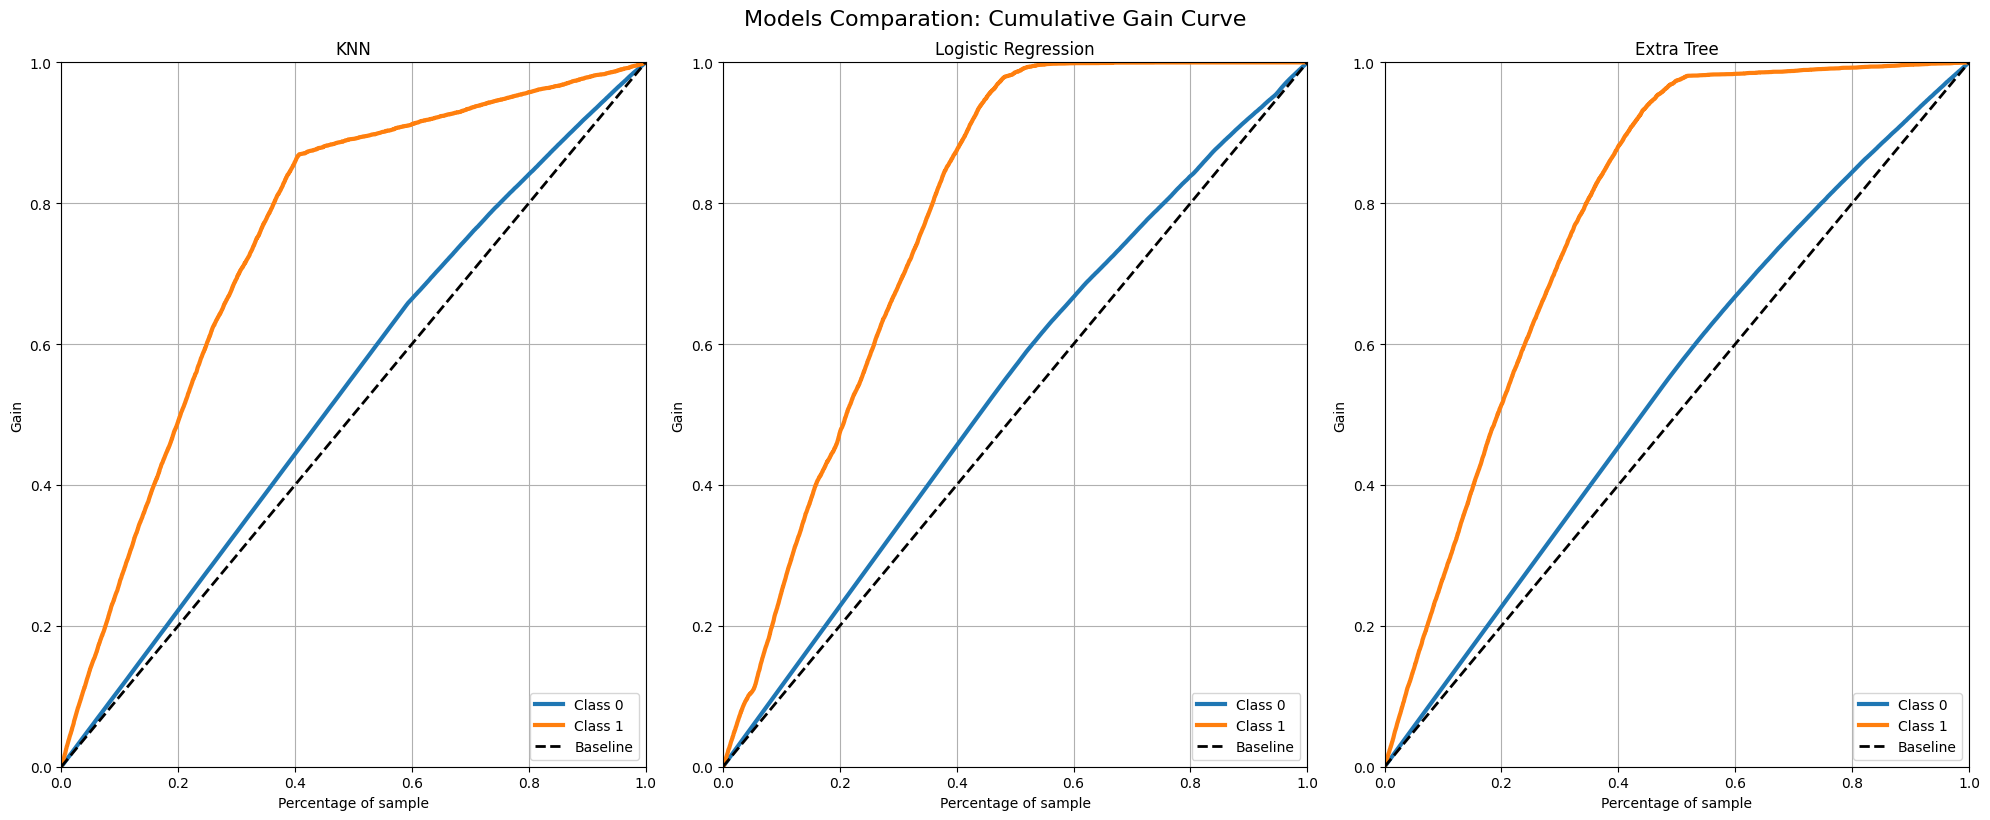

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# KNN
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axes[0])
axes[0].set_title('KNN')

# Logistic Regression
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axes[1])
axes[1].set_title('Logistic Regression')

# Extra Tree
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=axes[2])
axes[2].set_title('Extra Tree')

plt.tight_layout()
fig.suptitle('Models Comparation: Cumulative Gain Curve', fontsize=16, y=1.02)
plt.show()


## Ao final, vamos responder:

- x% da minha base de clientes, ordenados pela probabilidade de compra, contém y% de todos os interessados no novo produto.

## 10.5 Models Performance

In [55]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [57]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [59]:
df6 = x_validation.copy()
df6['response'] = y_validation.copy()

# propensity score
df6['score_knn'] = yhat_knn[:, 1].tolist()

# sorting customers by propensity score
df6 = df6.sort_values('score_knn', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df6, k=50)
print(f'Precision at k: {precision_at_50}')

# compute recall at k
recall_at_50 = recall_at_k(df6, k=50)
print(f'Recall at k: {recall_at_50}')

Precision at k: 0.4117647058823529
Recall at k: 0.0022335673261008296


In [60]:
# propensity score
df6['score_logistic'] = yhat_lr[:, 1].tolist()

# sorting customers by propensity score
df6 = df6.sort_values('score_logistic', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df6, k=50)
print(f'Precision at k: {precision_at_50}')

# compute recall at k
recall_at_50 = recall_at_k(df6, k=50)
print(f'Recall at k: {recall_at_50}')

Precision at k: 0.09803921568627451
Recall at k: 0.0005318017443097213


In [61]:
# propensity score
df6['score_et'] = yhat_et[:, 1].tolist()

# sorting customers by propensity score
df6 = df6.sort_values('score_et', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df6, k=50)
print(f'Precision at k: {precision_at_50}')

# compute recall at k
recall_at_50 = recall_at_k(df6, k=50)
print(f'Recall at k: {recall_at_50}')

Precision at k: 0.13725490196078433
Recall at k: 0.0007445224420336099
